In [1]:
# Importamos librerías
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Funciones

In [2]:
#función para visualizar las diferentes opciones por columna en el caso de las categoricas o el máximo y mínimo en el caso de columnas numéricas
def ver_opciones_por_columna(df):
    lista_tipo=['O']
    lista_tipo_num=['float64','int64']
    opciones ={'Columnas':[], 'Opciones por Columna':[]}
    for c in list(df.columns):
        if df[c].dtypes in lista_tipo:
            opciones['Columnas'].append(c)
            opciones['Opciones por Columna'].append(df[c].unique())
            #print(c, ':   ',df[c].unique() )
        elif df[c].dtypes in lista_tipo_num: 
            lista_max_min= [df[c].max(), df[c].min()]
            opciones['Columnas'].append(c)
            opciones['Opciones por Columna'].append(lista_max_min)
            lista_max_min=[]
            #print(c, ':   ',lista_max_min )
            
    pd.set_option('max_rows', None)
    pd.set_option('max_columns', 500)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_colwidth',None)         
    
    return pd.DataFrame(opciones)

#función para contar ouliers
def contar_outliers(df):
    numero_de_outliers ={'Columnas':[], 'Numero Outliers':[]}
    for  column in range(df.shape[1]):
        lista_tipo=['float64', 'int64']
        if (df.iloc[:,column]).dtypes in lista_tipo:
            df_data=df.iloc[:,column]
            q1 = df_data.quantile(q=0.25)
            q2 = df_data.quantile(q=0.5)
            q3 = df_data.quantile(q=0.75)
            iqr = q3 - q1
            upper = q3 + 1.5 * iqr
            lower = q1 - 1.5 * iqr    
            #Contar número de outliers
            ubicacion_outliers = (df_data<lower) | (df_data>upper)
            numero_outliers = ubicacion_outliers[ubicacion_outliers==True].sum()
            #print(numero_outliers)
            # Agrego suma de outliers por columna
            numero_de_outliers['Columnas'].append(df.columns[column])
            numero_de_outliers['Numero Outliers'].append(numero_outliers)    
            
    return pd.DataFrame(numero_de_outliers).sort_values('Numero Outliers', ascending=False)

def calcular_porcentaje_de_unknown(dataframe_1):
    porcentaje_faltantes ={'Columnas':[], 'Porcentaje_Unknown':[]}
    for c in list(dataframe_1.columns):
        porcentaje_faltantes['Columnas'].append(c)
        sum_val_unknown=  dataframe_1[dataframe_1[c]== 'nan'][c].count()  + dataframe_1[dataframe_1[c]== np.nan][c].count()                                 
        porcentaje_calculado=sum_val_unknown*100/dataframe_1.shape[0]
        porcentaje_faltantes['Porcentaje_Unknown'].append(porcentaje_calculado)
    return pd.DataFrame(porcentaje_faltantes).sort_values('Porcentaje_Unknown', ascending=False)

# Datos

### **I.**	Exploración y Visualización de datos

#### 1. ¿Qué definición y dimensiones tienen los datos?

**Tabla 1**, Definiciones de los campos

|No | Campos | Definición | Tipo de Dato |
| --- | --- | --- | --- |
|1.    | OBJECTID | Identificador del objeto | str |
|2.    | x_geo | Información de coordenadas geográficas | int |
|3.    | y_geo  | Información de coordenadas geográficas | int |
|4.    | p_s6p46 | Variable códificada que representa la información del tipo de cultivo o plantación forestal que está en el lote   | str |
|5.    | MPIO_CDPMP | Código del municipio | str |
|6.    |cultivo | Tipo de cultivo  | str |
|7.    |MPIO_cultivo | código del municipio y tipo de cultivo | str |
|8.    |rend | Rendimiento (t/ha) | int |
|9.    |prod| Producción obtenida (t)| int |
|10.    |area_cos| Área cosechada de los cultivos (ha)| int |
|11.    |Periodicid| Frecuencia con la que se realiza siembra del cultivo en el lote | str |
|12.    |Cultivo_1| Cultivo anterior| str |

Vemos que la base de datos contiene información geográfica así como rendimientos, áreas de cosecha y producción

In [3]:
#Cargamos los datos de las UPAs
df = pd.read_excel('datos/Rendimientos_upa_municipios.xlsx', sheet_name='Rendimientos_upa_municipios')

In [4]:
#Cargamos la base de datos complementaria de los códigos de la división política de Colombia (municipios y departamentos)
divipola = pd.read_csv('datos/DIVIPOLA-_C_digos_municipios.csv')

In [5]:
print('--> La tabla de datos  tiene ', df.shape[0], ' filas  y  ', df.shape[1], ' columnas')

--> La tabla de datos  tiene  1048575  filas  y   13  columnas


- 7 variables categóricas y 6 variables numéricas

#### 2. Tipo de datos 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   TARGET_FID    1048575 non-null  int64  
 1   OBJECTID      1048575 non-null  int64  
 2   x_geo         1048575 non-null  float64
 3   y_geo         1048575 non-null  float64
 4   p_s6p46       1048575 non-null  int64  
 5   MPIO_CDPMP    1048352 non-null  float64
 6   cultivo       1048575 non-null  object 
 7   MPIO_cultivo  1048575 non-null  object 
 8   rend          1048575 non-null  float64
 9   prod          1048575 non-null  float64
 10  area_cos      1048575 non-null  float64
 11  Periodicid    1047322 non-null  object 
 12  Cultivo_1     1047322 non-null  object 
dtypes: float64(6), int64(3), object(4)
memory usage: 104.0+ MB


In [7]:
#Transformamos variables que son llaves para otras bases de datos a texto
df['MPIO_CDPMP']= df['MPIO_CDPMP'].astype('str')
df['p_s6p46']= df['p_s6p46'].astype('str')

#### 4. ¿Cuántos valores desconocidos y outliers existen para cada columna?

- Definimos las variables de interés

In [9]:
#Seleccionamos las variables de interés
df_01=df.loc[:, ['rend','prod','area_cos']]

In [10]:
#Cálculamos outliers de acuerdo con la función definida en un comienzo
contar_outliers(df_01).head(60)

Columnas  Numero Outliers
0      rend           153888
2  area_cos           119419
1      prod           107416

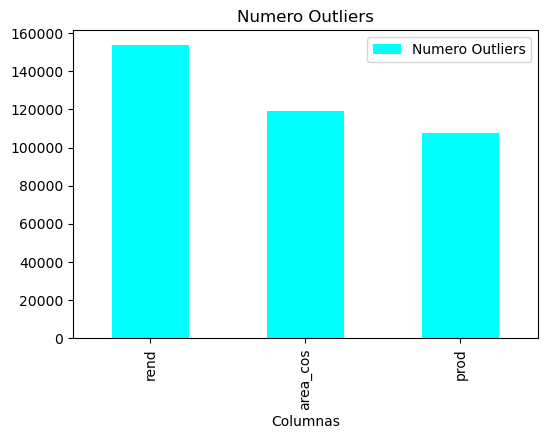

In [11]:
#Gráficamos la cantidad de outliers encontrados
plt.rcParams["figure.figsize"] = (6,4)
pn=contar_outliers(df_01.iloc[:,0:]).set_index('Columnas')
ax = pn.plot.bar(color = 'cyan', title = 'Numero Outliers')
plt.show()

Tenemos varios outliers en la base de datos especialmente en la variable rendimiento.

In [12]:
#Cálculo de nulos en porcentaje del total
calcular_porcentaje_de_unknown(df)

Columnas  Porcentaje_Unknown
5     MPIO_CDPMP            0.021267
0     TARGET_FID            0.000000
1       OBJECTID            0.000000
2          x_geo            0.000000
3          y_geo            0.000000
4        p_s6p46            0.000000
6        cultivo            0.000000
7   MPIO_cultivo            0.000000
8           rend            0.000000
9           prod            0.000000
10      area_cos            0.000000
11    Periodicid            0.000000
12     Cultivo_1            0.000000

Para el producto Soya que lo tendremos como primer análisis, vemos la disposición geográfica de las Unidades Priductivas Agrícolas UPA, estas son en definición fincas o grupo de fincas.

In [21]:
#mapa de las UPAs tomando como ejemplo la soya
import folium
import pandas as pd
from branca.colormap import LinearColormap

m = folium.Map(location=[4.570868, -74.297333], zoom_start=5)
data = df[df['cultivo']=='Soja (Soya)'].copy()
colormap = LinearColormap(['lightblue', 'blue'], vmin=data['prod'].min(), vmax=data['prod'].max())

for index, row in data.iterrows():
    folium.CircleMarker(
        location=[row['y_geo'], row['x_geo']],
        radius=5,
        color='blue',
        fill_color='gray',
        fill_opacity=0.7,
    ).add_to(m)

m

#### 4.1 Descripción de los datos 

La descripción de los datos nos muestra valores muy altos en las variables, con una media relativamente pequeña en comparación con los máximos observados, podemos ver como en la mediana se aleja un poco de la media por estos valores extremos.

In [24]:
df_01.describe().T

count       mean         std       min       25%       50%  \
rend      1048575.0  56.964931  154.937324  0.000003  2.188330  8.791615   
prod      1048575.0  10.829576  149.627018  0.000004  3.071679  5.060987   
area_cos  1048575.0   3.491945   48.083071  0.006200  0.143554  0.613336   

                75%          max  
rend      37.789953  11420.76465  
prod       8.538944  86899.68240  
area_cos   2.112488  20000.00000

#### 5.     Relacion entre variables

In [25]:
df_01.corr(method="pearson")

rend      prod  area_cos
rend      1.000000  0.009471 -0.025247
prod      0.009471  1.000000  0.237365
area_cos -0.025247  0.237365  1.000000

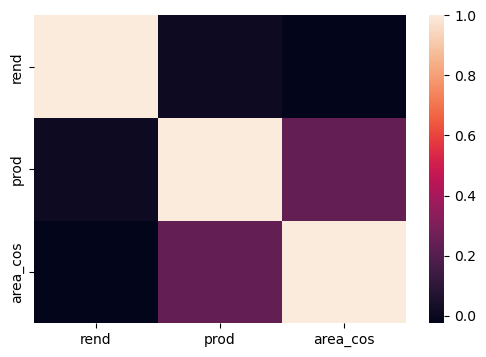

In [26]:
sns.heatmap(df_01.corr())
plt.show()

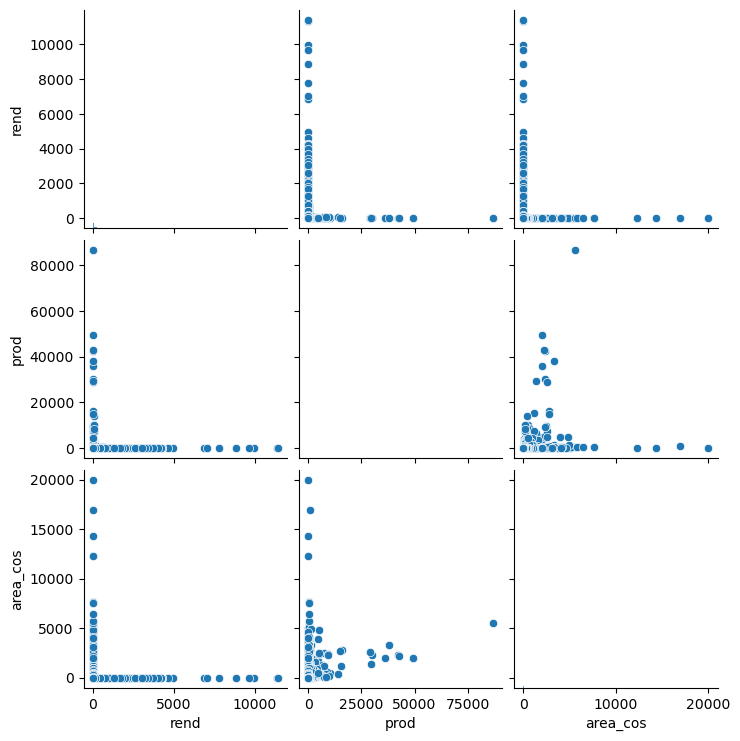

In [27]:
#Gráfica de dispersión de las variables de interés
sns.pairplot(df_01)
plt.show()

Concluimos que no hay correlación entre las variables y tampoco linealidad, como podemos observar en las gráficas anteriores.

#### Histogramas

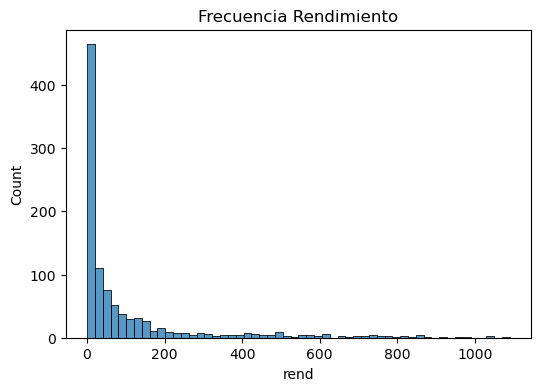

In [28]:
sns.histplot(x=df.rend.iloc[:1000]).set(title='Frecuencia Rendimiento'); 
plt.rcParams["figure.figsize"] = (6,4)
plt.show()

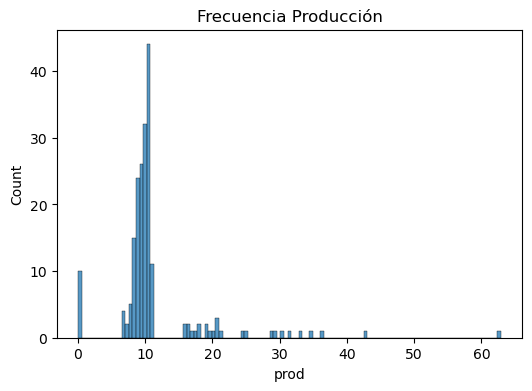

In [29]:
sns.histplot(x=df['prod'].iloc[:200]).set(title='Frecuencia Producción'); 
plt.show()

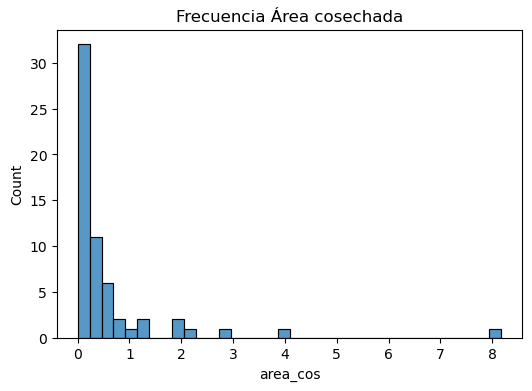

In [30]:
sns.histplot(x=df.area_cos.iloc[:60]).set( title='Frecuencia Área cosechada');  
plt.show()

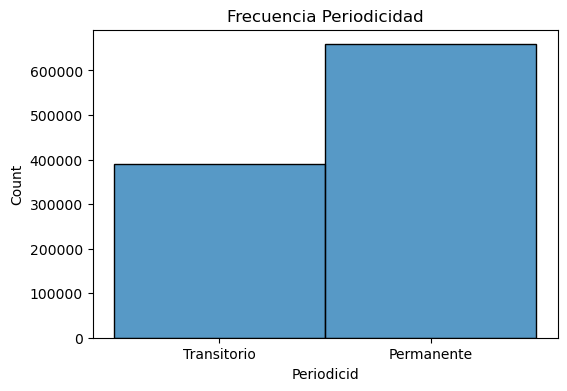

In [31]:
sns.histplot(x=df.Periodicid).set( title='Frecuencia Periodicidad'); 
plt.rcParams["figure.figsize"] = (6,4)
plt.show()

In [32]:
#Agrupamos por cúltimo y tomamos la suma de producción y área cosechada, y el promedio del rendimiento
df_01=df.groupby('cultivo').agg({ 'prod': 'sum', 'area_cos': 'sum',  'rend': 'mean'}).reset_index()

In [33]:
#Se ordenan de mayor a menor por producción
df_02=df_01.sort_values('prod',ascending=False)

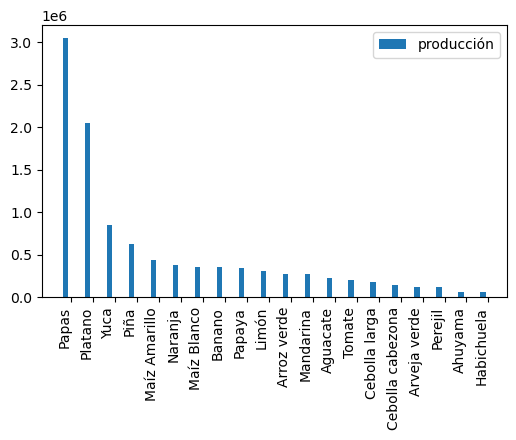

In [34]:
#Gráfico del top 20 de productos con más producción
fig = plt.figure()
n = len(df_02.cultivo.iloc[:20])
x = np.arange(n)
width = 0.25
plt.bar(x - width, df_02['prod'].iloc[:20], width=width, label='producción')
plt.xticks(x, df_02.cultivo.iloc[:20])
plt.legend(loc='best')
fig.autofmt_xdate(rotation=90)
plt.rcParams["figure.figsize"] = (6,4)
plt.show()

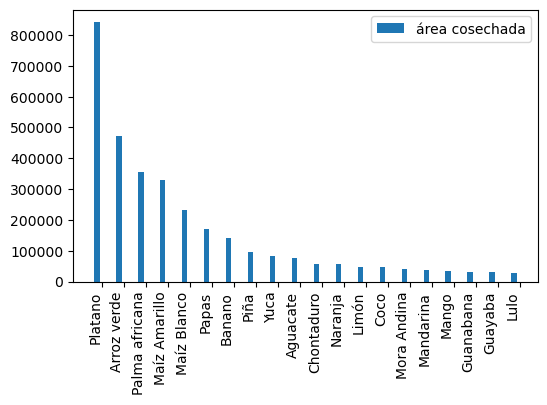

In [35]:
#Gráfico de productos con mayor área cosechada
df_03=df_01.sort_values('area_cos',ascending=False)
fig = plt.figure()
n = len(df_03.cultivo.iloc[:20])
x = np.arange(n)
width = 0.25
plt.bar(x - width, df_03['area_cos'].iloc[:20], width=width, label='área cosechada')
plt.xticks(x, df_03.cultivo.iloc[:20])
plt.legend(loc='best')
fig.autofmt_xdate(rotation=90)
plt.rcParams["figure.figsize"] =  (6,4)
plt.show()

<Figure size 1000x600 with 0 Axes>

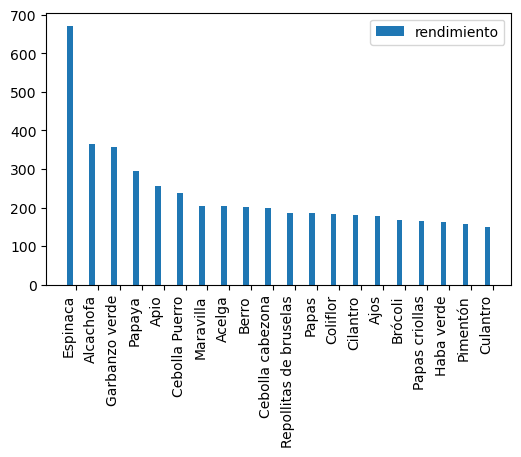

In [36]:
#Gráfico del top 20 de los productos con mayor rendimiento
df_04=df_01.sort_values('rend',ascending=False)
plt.figure(figsize=(10,6))
fig = plt.figure()
n = len(df_04.cultivo.iloc[:20])
x = np.arange(n)
width = 0.25
plt.bar(x - width, df_04['rend'].iloc[:20], width=width, label='rendimiento')
plt.xticks(x, df_04.cultivo.iloc[:20])
plt.legend(loc='best')
fig.autofmt_xdate(rotation=90)
plt.rcParams["figure.figsize"] =  (6,4)
plt.show()

# Desarrollo del algoritmo

In [37]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from kneed import KneeLocator

In [38]:
df.head()

TARGET_FID  OBJECTID      x_geo     y_geo    p_s6p46 MPIO_CDPMP cultivo  \
0      241972    241973 -75.661598  6.297552  121904001     5001.0  Acelga   
1      242013    242014 -75.631668  6.294356  121904001     5001.0  Acelga   
2      242040    242041 -75.655678  6.304490  121904001     5001.0  Acelga   
3      242055    242056 -75.611473  6.257732  121904001     5001.0  Acelga   
4      242099    242100 -75.655792  6.301595  121904001     5001.0  Acelga   

  MPIO_cultivo       rend       prod  area_cos   Periodicid Cultivo_1  
0  05001Acelga  21.651312   8.364622  0.386333  Transitorio    Acelga  
1  05001Acelga  46.166847   8.712359  0.188715  Transitorio    Acelga  
2  05001Acelga  33.799198   8.145967  0.241011  Transitorio    Acelga  
3  05001Acelga   4.384921  17.201645  3.922909  Transitorio    Acelga  
4  05001Acelga  62.047428   9.225109  0.148678  Transitorio    Acelga

In [39]:
#Selección de variables a usar en el modelo
df1 = df[['x_geo', 'y_geo', 'MPIO_CDPMP', 'cultivo', 
          'rend', 'prod', 'area_cos']].copy()
#Transformación a númerico el código del municipio
df1['MPIO_CDPMP'] = df1['MPIO_CDPMP'].astype(float)
#Eliminación de nulos
df1 = df1.dropna()

In [40]:
#Transformación a entero del código de municipio
df1['MPIO_CDPMP'] = df1['MPIO_CDPMP'].astype(int)
#Unión con la base de Divipola para obtener los nombres de los departamentos
coldivi = ['Código Departamento', 'Código Municipio', 'Nombre Departamento', 'Nombre Municipio']
df1 = df1.merge(divipola[coldivi], left_on='MPIO_CDPMP', right_on='Código Municipio')
df1.head()

x_geo     y_geo  MPIO_CDPMP cultivo       rend       prod  area_cos  \
0 -75.661598  6.297552        5001  Acelga  21.651312   8.364622  0.386333   
1 -75.631668  6.294356        5001  Acelga  46.166847   8.712359  0.188715   
2 -75.655678  6.304490        5001  Acelga  33.799198   8.145967  0.241011   
3 -75.611473  6.257732        5001  Acelga   4.384921  17.201645  3.922909   
4 -75.655792  6.301595        5001  Acelga  62.047428   9.225109  0.148678   

   Código Departamento  Código Municipio Nombre Departamento Nombre Municipio  
0                    5              5001           ANTIOQUIA         MEDELLÍN  
1                    5              5001           ANTIOQUIA         MEDELLÍN  
2                    5              5001           ANTIOQUIA         MEDELLÍN  
3                    5              5001           ANTIOQUIA         MEDELLÍN  
4                    5              5001           ANTIOQUIA         MEDELLÍN

In [41]:
#Observamos los productos que más se siembran en las UPA
df1.groupby(by='cultivo').count().sort_values(by='x_geo',ascending=False)

x_geo   y_geo  MPIO_CDPMP    rend    prod  \
cultivo                                                                    
Platano                       298259  298259      298259  298259  298259   
Maíz Amarillo                 107172  107172      107172  107172  107172   
Maíz Blanco                    81627   81627       81627   81627   81627   
Banano                         61711   61711       61711   61711   61711   
Papas                          34321   34321       34321   34321   34321   
...                              ...     ...         ...     ...     ...   
Pomarroso- Manzanita De Rosa       2       2           2       2       2   
Turmademico                        1       1           1       1       1   
Guanabanillo- Caimitillo           1       1           1       1       1   
Guanabanitaepuy- Maguey            1       1           1       1       1   
Hombre Solo                        1       1           1       1       1   

                              area_cos  Código Departamento  Código Municipio  \
cultivo                                                                         
Platano                         298259               298259            298259   
Maíz Amarillo                   107172               107172            107172   
Maíz Blanco                      81627                81627             81627   
Banano                           61711                61711             61711   
Papas                            34321                34321             34321   
...                                ...                  ...               ...   
Pomarroso- Manzanita De Rosa         2                    2                 2   
Turmademico                          1                    1                 1   
Guanabanillo- Caimitillo             1                    1                 1   
Guanabanitaepuy- Maguey              1                    1                 1   
Hombre Solo                          1                    1                 1   

                              Nombre Departamento  Nombre Municipio  
cultivo                                                              
Platano                                    298259            298259  
Maíz Amarillo                              107172            107172  
Maíz Blanco                                 81627             81627  
Banano                                      61711             61711  
Papas                                       34321             34321  
...                                           ...               ...  
Pomarroso- Manzanita De Rosa                    2                 2  
Turmademico                                     1                 1  
Guanabanillo- Caimitillo                        1                 1  
Guanabanitaepuy- Maguey                         1                 1  
Hombre Solo                                     1                 1  

[164 rows x 10 columns]

In [42]:
#Agrupación por departamento, cantidad de UPA por departamento
df1.groupby(by='Nombre Departamento').count().sort_values(by='x_geo',ascending=False)

x_geo   y_geo  \
Nombre Departamento                                                  
NARIÑO                                              119705  119705   
CAUCA                                               116019  116019   
CHOCÓ                                                73190   73190   
TOLIMA                                               72541   72541   
ANTIOQUIA                                            66845   66845   
CUNDINAMARCA                                         53184   53184   
VALLE DEL CAUCA                                      50131   50131   
BOYACÁ                                               49978   49978   
SANTANDER                                            45470   45470   
CÓRDOBA                                              35586   35586   
HUILA                                                34838   34838   
CALDAS                                               34182   34182   
BOLÍVAR                                              34141   34141   
META                                                 25777   25777   
LA GUAJIRA                                           22571   22571   
CAQUETÁ                                              22016   22016   
CESAR                                                21353   21353   
MAGDALENA                                            20678   20678   
PUTUMAYO                                             20252   20252   
NORTE DE SANTANDER                                   19688   19688   
CASANARE                                             17649   17649   
SUCRE                                                14809   14809   
RISARALDA                                            12639   12639   
AMAZONAS                                             10748   10748   
QUINDÍO                                              10115   10115   
VICHADA                                               9995    9995   
GUAVIARE                                              8711    8711   
VAUPÉS                                                7373    7373   
ARAUCA                                                7211    7211   
GUAINÍA                                               6957    6957   
ATLÁNTICO                                             2314    2314   
BOGOTÁ. D.C.                                          1003    1003   
ARCHIPIÉLAGO DE SAN ANDRÉS. PROVIDENCIA Y SANTA...     660     660   

                                                    MPIO_CDPMP  cultivo  \
Nombre Departamento                                                       
NARIÑO                                                  119705   119705   
CAUCA                                                   116019   116019   
CHOCÓ                                                    73190    73190   
TOLIMA                                                   72541    72541   
ANTIOQUIA                                                66845    66845   
CUNDINAMARCA                                             53184    53184   
VALLE DEL CAUCA                                          50131    50131   
BOYACÁ                                                   49978    49978   
SANTANDER                                                45470    45470   
CÓRDOBA                                                  35586    35586   
HUILA                                                    34838    34838   
CALDAS                                                   34182    34182   
BOLÍVAR                                                  34141    34141   
META                                                     25777    25777   
LA GUAJIRA                                               22571    22571   
CAQUETÁ                                                  22016    22016   
CESAR                                                    21353    21353   
MAGDALENA                                                20678    20678   
PUTUMAYO                                                 20252    20252   
NORTE DE SANTANDER         

Se escoge Nariño como piloto para el ejercicio

In [43]:
#Selección de columnas
columnas = ['x_geo', 'y_geo',
            #'cultivo', 'rend',
            #'prod', 'area_cos',
            'potencial_prod']

X = df1[df1['cultivo']=='Soja (Soya)'].copy()
#Cálculamos el potencial de producción multiplicando el potencial de rendimiento (cálculado con el quantile 90) por el área de la UPA
rend_max = X.rend.quantile(.90)
X['potencial_prod'] = np.where( ((rend_max - X.rend) * X.area_cos) <0, 0,  ((rend_max - X.rend) * X.area_cos) )

X = X[columnas]

In [44]:
X.head()

x_geo     y_geo  potencial_prod
7695  -75.902840  6.533135      290.316526
7879  -75.916565  6.294940      351.649728
8735  -76.582825  7.859476      174.330272
10079 -76.411446  8.607202     1560.605352
16058 -75.103668  7.580066      393.379786

In [45]:
# Escalamos las imágenes del dataset y observamos el dataframe resultante de dicha transformación
mu = X.mean()
sigma = X.std()
Z = (X - mu) / sigma

## K-means

El coeficiente de Silhouette es de 0.6000 para 2 de clústeres
El coeficiente de Silhouette es de 0.6025 para 3 de clústeres
El coeficiente de Silhouette es de 0.6056 para 4 de clústeres
El coeficiente de Silhouette es de 0.6122 para 5 de clústeres
El coeficiente de Silhouette es de 0.5155 para 6 de clústeres
El coeficiente de Silhouette es de 0.5110 para 7 de clústeres
El coeficiente de Silhouette es de 0.5104 para 8 de clústeres
El coeficiente de Silhouette es de 0.5122 para 9 de clústeres
El coeficiente de Silhouette es de 0.5042 para 10 de clústeres


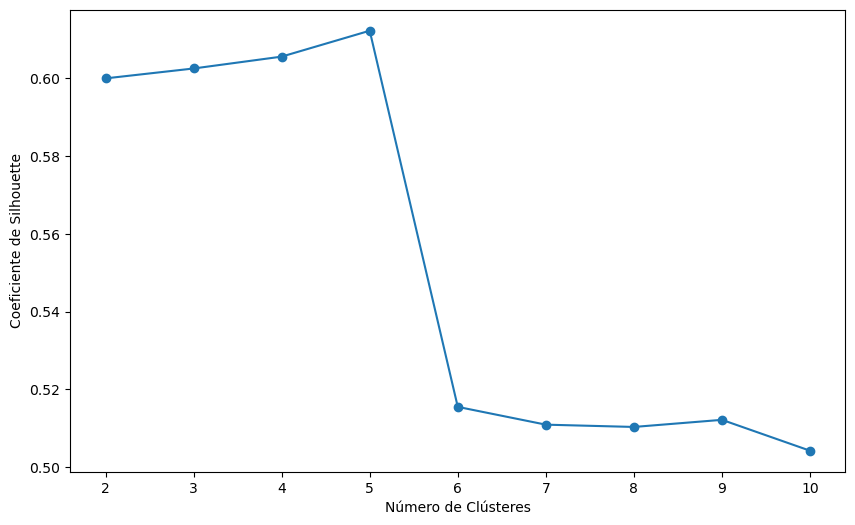

El número óptimo de clústers para un rango entre 0 y 10 es de 5


In [46]:
# Definimos el rango de valores de clústeres a probar
min_clusters = 2
max_clusters = 10

# Almacenamos los valores del coeficiente de Silhouette en una lista
silhouette_scores = []

# Probamos diferentes números de clústeres
for n_clusters in range(min_clusters, max_clusters + 1, 1):
    if n_clusters != 0:
        kmeans = KMeans(n_clusters = n_clusters, random_state = 123)
        pred_etiquetas = kmeans.fit_predict(np.array(Z))
        silhouette = silhouette_score(np.array(Z), pred_etiquetas)
        silhouette_scores.append(silhouette)
        print(f'El coeficiente de Silhouette es de {silhouette:.4f} para {n_clusters} de clústeres')

# Graficamos el coeficiente de Silhouette para diferentes números de clústeres
plt.figure(figsize = (10, 6))
plt.plot(range(min_clusters, max_clusters + 1, 1), silhouette_scores, marker = 'o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Coeficiente de Silhouette')
plt.show()

# Identificamos el índice con el coeficiente de Silhouette más alto
k_optimo = (silhouette_scores.index(max(silhouette_scores))+2)
print(f'El número óptimo de clústers para un rango entre 0 y 10 es de {k_optimo}')

In [47]:
#Modelo de kmeans ajustado con 5 clusters
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = 123)
pred_etiquetas = kmeans.fit_predict(np.array(Z))
silhouette = silhouette_score(np.array(Z), pred_etiquetas)
print(f'El coeficiente de Silhouette es de {silhouette:.4f} para {n_clusters} de clústeres')

El coeficiente de Silhouette es de 0.6122 para 5 de clústeres


In [48]:
#Agregamos los resultados a la base inicial
Xkmeans = X.copy()
Xkmeans['Cluster'] = pred_etiquetas
#Conteo de cantidad de UPAs por cluster
Xkmeans.groupby(by='Cluster').count()

x_geo  y_geo  potencial_prod
Cluster                              
0         1206   1206            1206
1          203    203             203
2            1      1               1
3          360    360             360
4            5      5               5

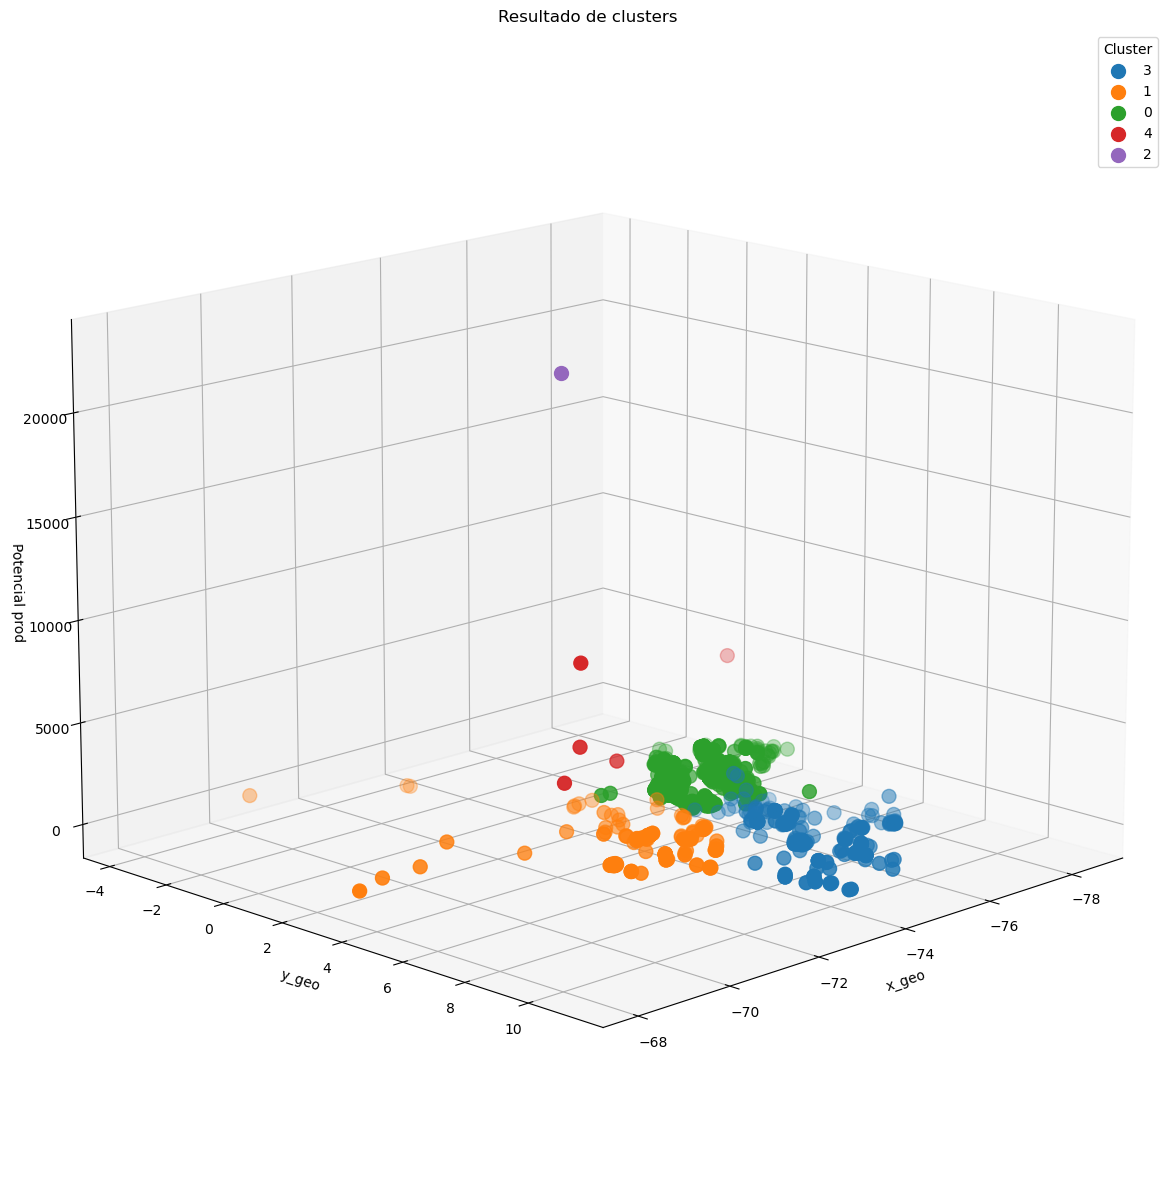

In [49]:
#Gráfico en 3D de las variables geográficas y potencial del rendimiento
plt.figure(figsize=(20, 15))
axes = plt.axes(projection = '3d')
for k in Xkmeans.Cluster.unique():
    data = Xkmeans[Xkmeans.Cluster == k]
    x = data.x_geo
    y = data.y_geo
    z = data.potencial_prod
    axes.scatter3D( x, y, z, label=k, s=100)
plt.title('Resultado de clusters')
axes.set_xlabel('x_geo')
axes.set_ylabel('y_geo')
axes.set_zlabel('Potencial prod')
axes.view_init(15,45)
plt.legend(title='Cluster')
plt.show()

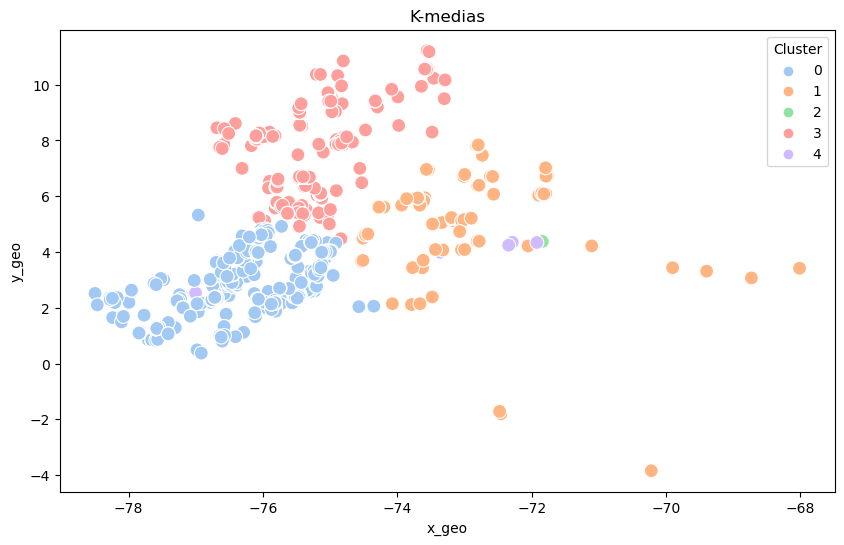

In [50]:
#Gráfica de los cluster gráficando las coordenadas geográficas
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Xkmeans, x='x_geo', y='y_geo', hue='Cluster', palette='pastel', s=100)
plt.title('K-medias')
plt.xlabel('x_geo')
plt.ylabel('y_geo')
plt.legend(title='Cluster')
plt.show()

In [51]:
#Mapa de resultados de los Clusters
m = folium.Map(location=[4.570868, -74.297333], zoom_start=5)

colormap = LinearColormap(['lightblue', 'blue'], vmin=Xkmeans['potencial_prod'].min(), vmax=Xkmeans['potencial_prod'].max())

def asignar_color(row):
    group_color = {
        0: 'red',
        1: 'green',
        2: 'blue',
        3: 'purple',
        4: 'orange'
    }
    color = group_color.get(row['Cluster'], 'gray')
    return colormap(row['potencial_prod']), color

for index, row in Xkmeans.iterrows():
    rendimiento_color, grupo_color = asignar_color(row)
    folium.CircleMarker(
        location=[row['y_geo'], row['x_geo']],
        radius=5,
        color=grupo_color,
        fill_color=rendimiento_color,
        fill_opacity=0.7,
    ).add_to(m)

m

## K-medoids

In [52]:
# Implementamos el algoritmo de K-medoides
kmedoides = KMedoids(n_clusters = n_clusters, random_state = 8)

# Ajustamos el modelo y predecimos las etiquetas
pred_kmedoides = kmedoides.fit_predict(np.array(Z))

In [53]:
#Agregamos el resultado a la base inicial
Xkmedo = X.copy()
Xkmedo['Cluster'] = pred_kmedoides
#Conteo del resultado por cluster
Xkmedo.groupby(by='Cluster').count()

x_geo  y_geo  potencial_prod
Cluster                              
0          181    181             181
1          457    457             457
2          471    471             471
3          504    504             504
4          162    162             162

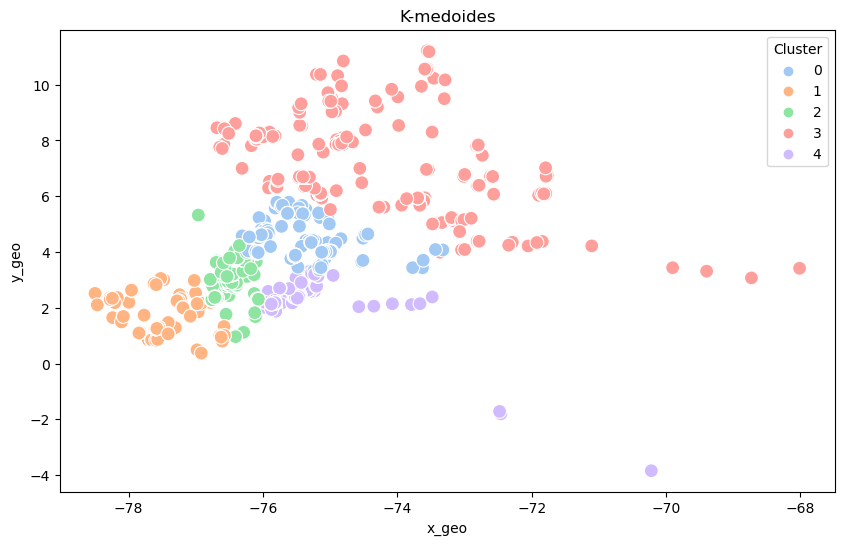

In [54]:
#Gráfica de los cluster gráficando las coordenadas geográficas
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Xkmedo, x='x_geo', y='y_geo', hue='Cluster', palette='pastel', s=100)
plt.title('K-medoides')
plt.xlabel('x_geo')
plt.ylabel('y_geo')
plt.legend(title='Cluster')
plt.show()

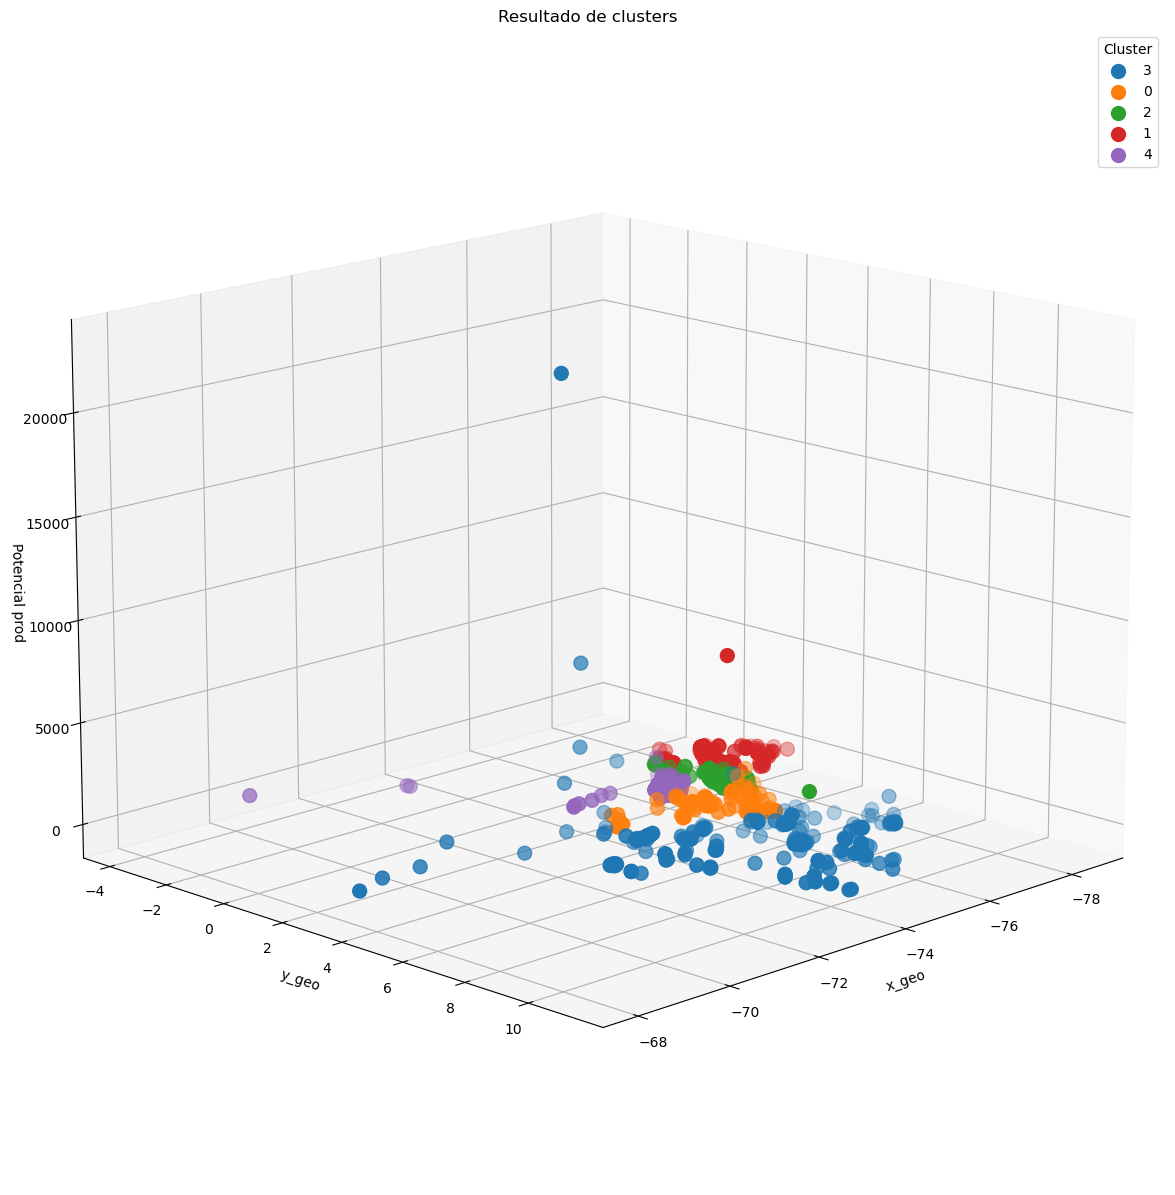

In [55]:
#Gráfico en 3D de las variables geográficas y potencial del rendimiento
plt.figure(figsize=(20, 15))
axes = plt.axes(projection = '3d')
for k in Xkmedo.Cluster.unique():
    data = Xkmedo[Xkmedo.Cluster == k]
    x = data.x_geo
    y = data.y_geo
    z = data.potencial_prod
    axes.scatter3D( x, y, z, label=k, s=100)
plt.title('Resultado de clusters')
axes.set_xlabel('x_geo')
axes.set_ylabel('y_geo')
axes.set_zlabel('Potencial prod')
axes.view_init(15,45)
plt.legend(title='Cluster')
plt.show()

In [56]:
#Mapa de resultados de los Clusters
m = folium.Map(location=[4.570868, -74.297333], zoom_start=5)

colormap = LinearColormap(['lightblue', 'blue'], vmin=Xkmedo['potencial_prod'].min(), vmax=Xkmedo['potencial_prod'].max())

def asignar_color(row):
    group_color = {
        0: 'red',
        1: 'green',
        2: 'blue',
        3: 'purple',
        4: 'orange'
    }
    color = group_color.get(row['Cluster'], 'gray')
    return colormap(row['potencial_prod']), color

for index, row in Xkmedo.iterrows():
    rendimiento_color, grupo_color = asignar_color(row)
    folium.CircleMarker(
        location=[row['y_geo'], row['x_geo']],
        radius=5,
        color=grupo_color,
        fill_color=rendimiento_color,
        fill_opacity=0.7,
    ).add_to(m)

m

## DBSCAN

In [57]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [58]:
neigh = NearestNeighbors(n_neighbors = 10)
nbrs = neigh.fit(Xs)
distancias, indices = nbrs.kneighbors(Xs)
distancias = np.sort(distancias.flatten())
i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')
print(distancias[knee.knee])

0.1588681346584942


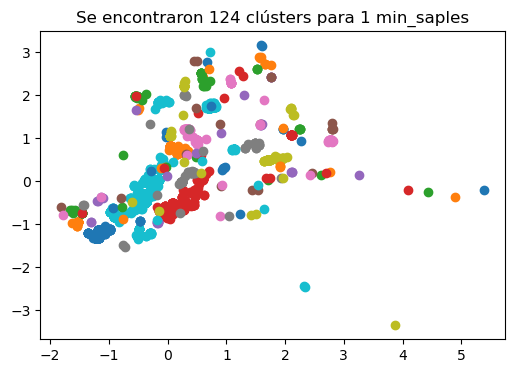

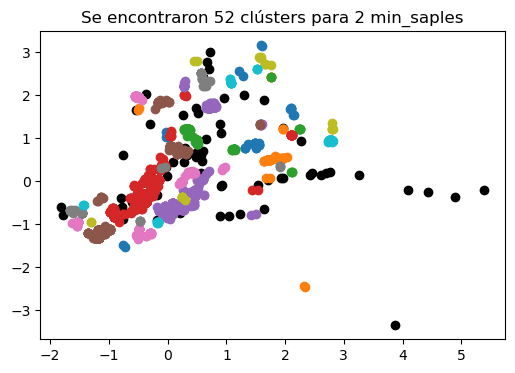

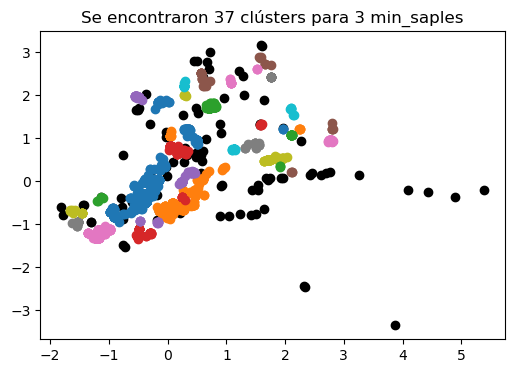

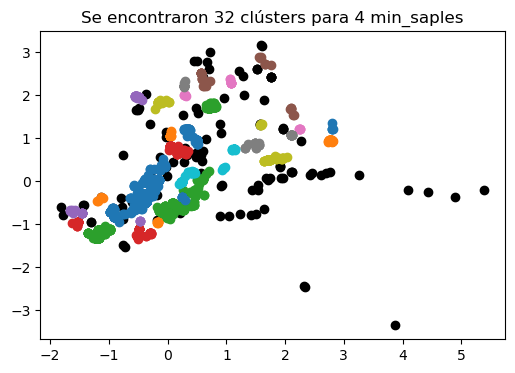

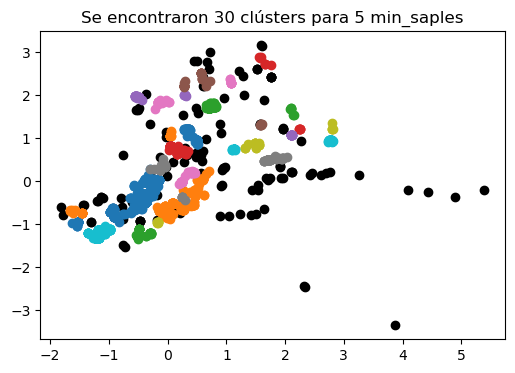

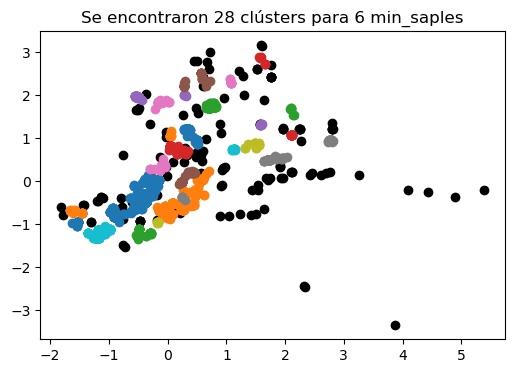

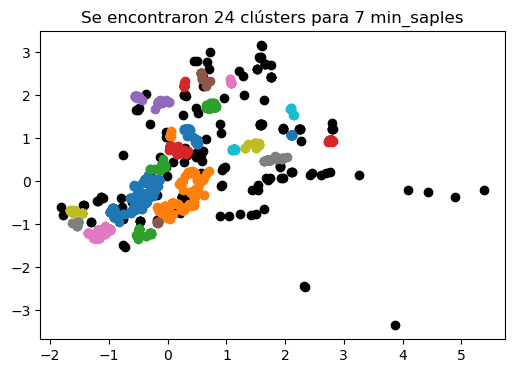

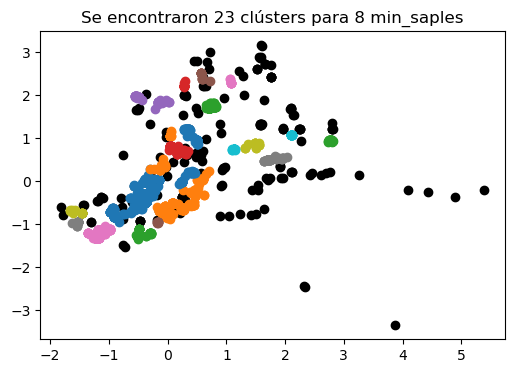

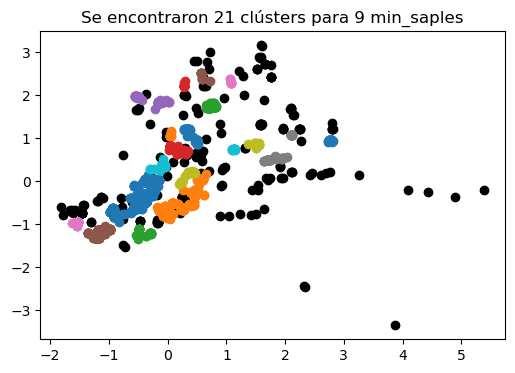

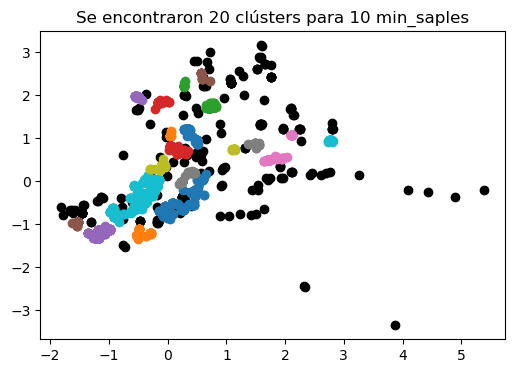

In [59]:
# Implementar DBSCAN para diferentes valores de min_samples
for i in np.arange(1, 11, 1):
    cluster_dbscan = DBSCAN(eps=distancias[knee.knee], min_samples=i).fit(Xs)
    n_clusters = len(set(cluster_dbscan.labels_)) - (1 if -1 in cluster_dbscan.labels_ else 0)
    resultado = pd.DataFrame(Xs).assign(Cluster = cluster_dbscan.labels_)
    plt.figure()
    for k in np.unique(cluster_dbscan.labels_):
        if k != -1:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0],
                y = resultado.loc[resultado.Cluster == k, 1]
                )
        else:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0],
                y = resultado.loc[resultado.Cluster == k, 1],
                c = "black"
                )
    plt.title(f'Se encontraron {n_clusters} clústers para {i} min_saples')

In [60]:
#Modelo DBSCAN ajuste y predicción
cluster_dbscan = DBSCAN(eps=distancias[knee.knee], min_samples=10).fit(Xs)
n_clusters = len(set(cluster_dbscan.labels_)) - (1 if -1 in cluster_dbscan.labels_ else 0)
#Agregamos los resultados a la base inicial
Xdb = pd.DataFrame(X).assign(Cluster = cluster_dbscan.labels_)

In [61]:
#Conteo del resultado por cluster
Xdb.groupby(by='Cluster').count()

x_geo  y_geo  potencial_prod
Cluster                              
-1         221    221             221
 0          77     77              77
 1          13     13              13
 2          97     97              97
 3          34     34              34
 4          18     18              18
 5          14     14              14
 6          44     44              44
 7          12     12              12
 8          17     17              17
 9         703    703             703
 10        177    177             177
 11         32     32              32
 12         15     15              15
 13         16     16              16
 14        134    134             134
 15         21     21              21
 16         14     14              14
 17         43     43              43
 18         23     23              23
 19         50     50              50

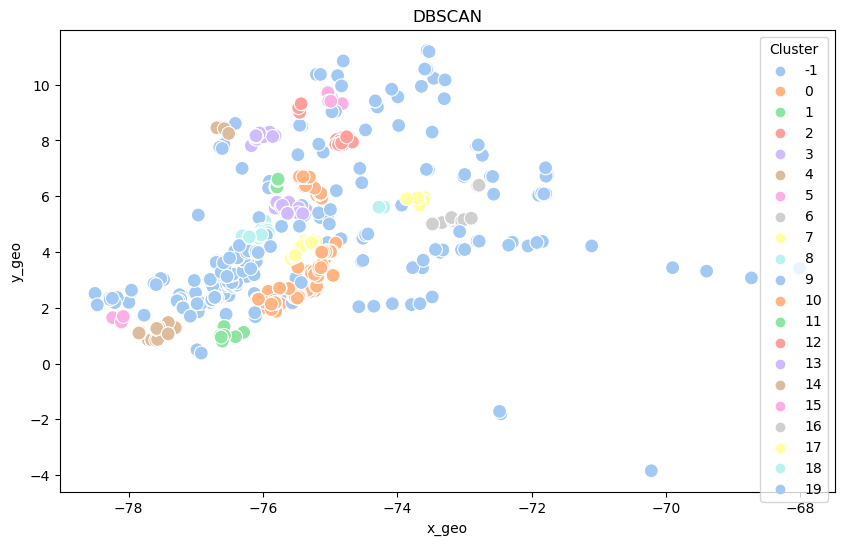

In [62]:
#Gráfica de los cluster gráficando las coordenadas geográficas
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Xdb, x='x_geo', y='y_geo', hue='Cluster', palette='pastel', s=100)
plt.title('DBSCAN')
plt.xlabel('x_geo')
plt.ylabel('y_geo')
plt.legend(title='Cluster')
plt.show()

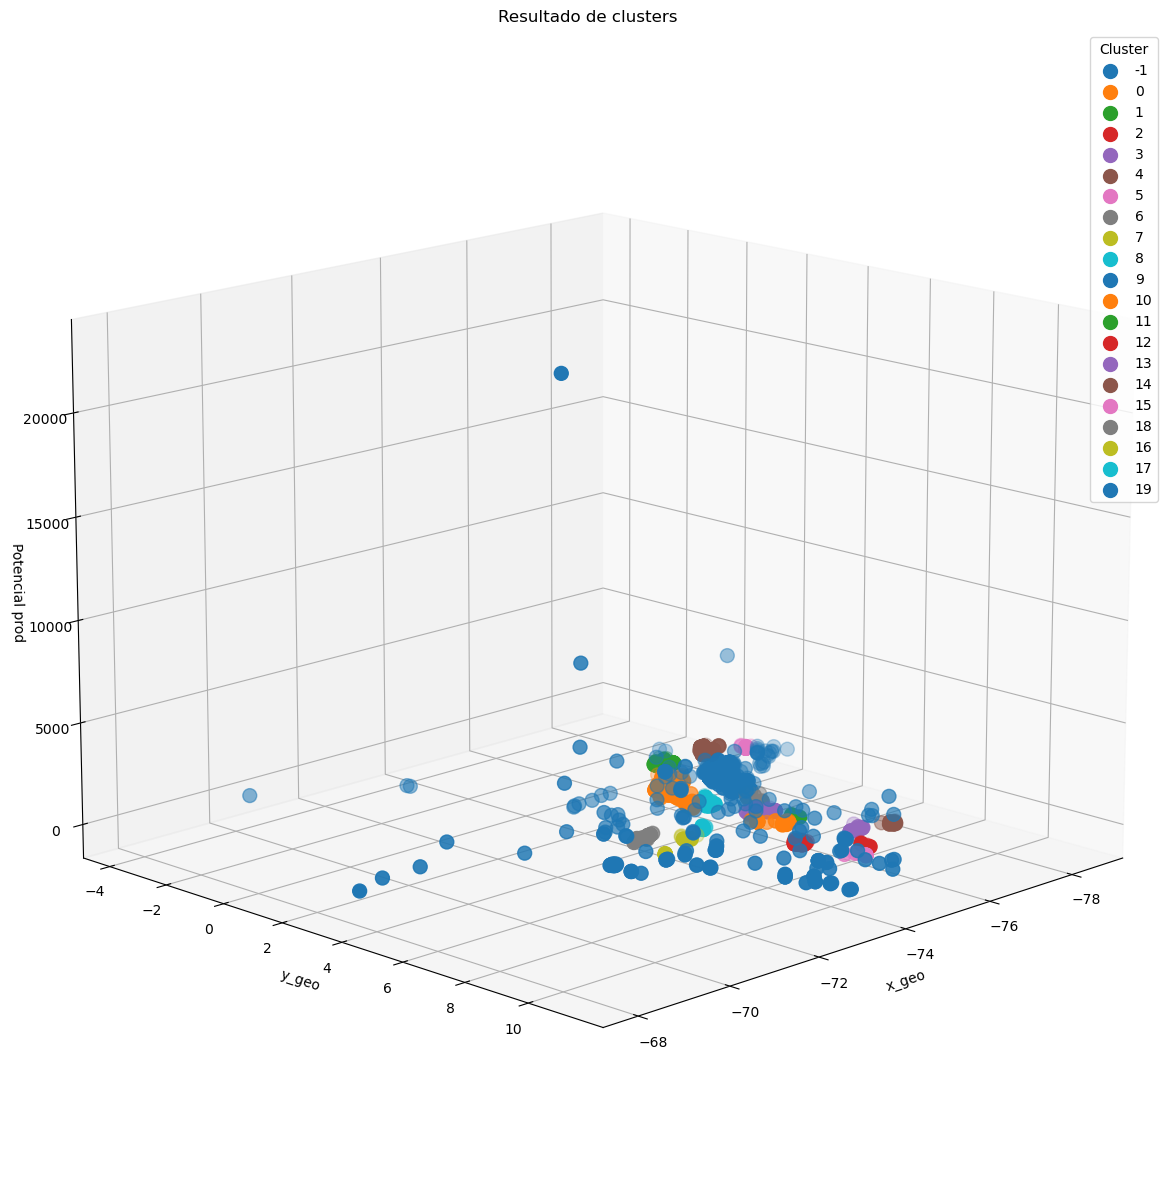

In [63]:
#Gráfico en 3D de las variables geográficas y potencial del rendimiento
plt.figure(figsize=(20, 15))
axes = plt.axes(projection = '3d')
for k in Xdb.Cluster.unique():
    data = Xdb[Xdb.Cluster == k]
    x = data.x_geo
    y = data.y_geo
    z = data.potencial_prod
    axes.scatter3D( x, y, z, label=k, s=100)
plt.title('Resultado de clusters')
axes.set_xlabel('x_geo')
axes.set_ylabel('y_geo')
axes.set_zlabel('Potencial prod')
axes.view_init(15,45)
plt.legend(title='Cluster')
plt.show()

In [64]:
#Mapa de resultados de los Clusters
m = folium.Map(location=[4.570868, -74.297333], zoom_start=5)

colormap = LinearColormap(['lightblue', 'blue'], vmin=Xdb['potencial_prod'].min(), vmax=Xdb['potencial_prod'].max())

def asignar_color(row):
    group_color = {
        -1: 'red',
        0: 'green',
        1: 'blue',
        2: 'purple',
        3: 'orange',
        4: 'pink',
        5: 'brown',
        6: 'gray',
        7: 'cyan',
        8: 'lime',
        9: 'teal',
        10: 'magenta',
        11: 'indigo',
        12: 'gold',
        13: 'violet',
        14: 'olive',
        15: 'maroon',
        16: 'navy',
        17: 'turquoise',
        18: 'slategray',
        19: 'darkred'
    }
    color = group_color.get(row['Cluster'], 'gray')
    return colormap(row['potencial_prod']), color

for index, row in Xdb.iterrows():
    rendimiento_color, grupo_color = asignar_color(row)
    folium.CircleMarker(
        location=[row['y_geo'], row['x_geo']],
        radius=5,
        color=grupo_color,
        fill_color=rendimiento_color,
        fill_opacity=0.7,
    ).add_to(m)

m

## Algoritmo jerárquico aglomerativo

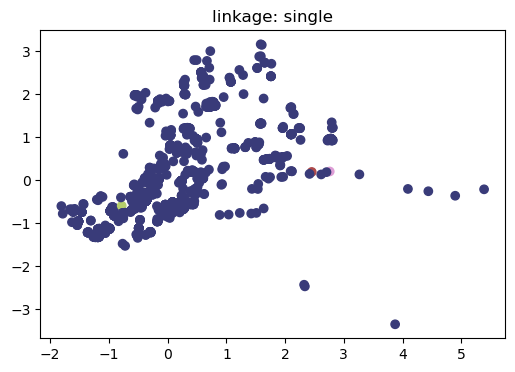

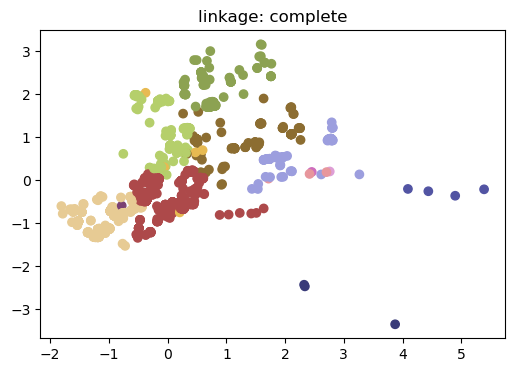

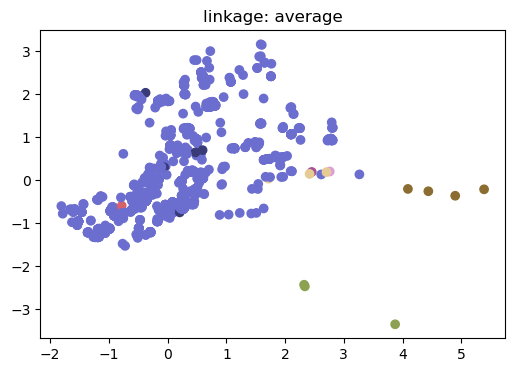

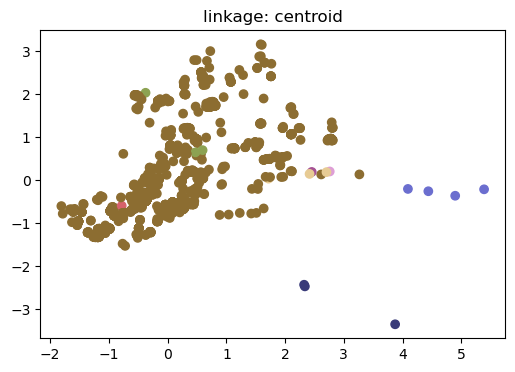

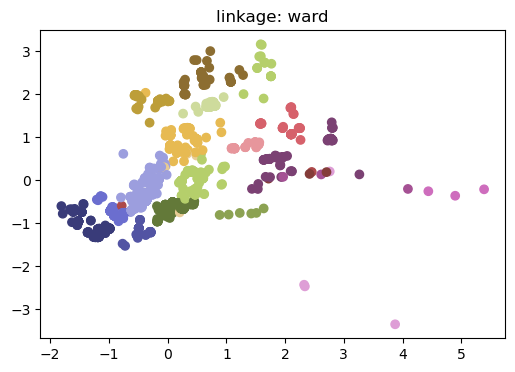

In [65]:
#Probamos diferentes metodos para el algoritmo jerárquico
methods = ['single', 'complete', 'average', 'centroid','ward']
for method in methods:
    distances = linkage(Xs, method=method, metric="euclidean")
    clusters = fcluster(distances, 3, criterion="distance")
    plt.title('linkage: ' + method)
    plt.scatter(Xs[:,0], Xs[:,1], c=clusters, cmap='tab20b')
    plt.show()

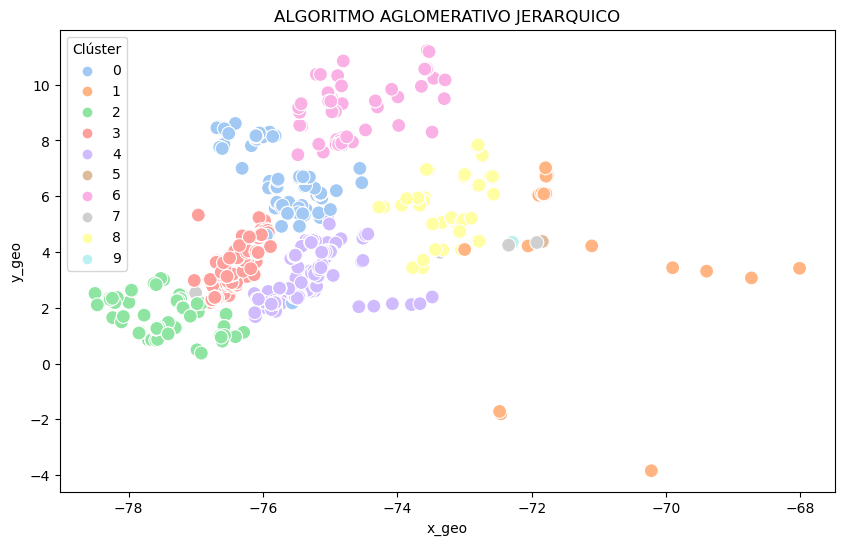

In [66]:
# Implementar el Algoritmo Jerárquico Aglomerativo
cluster_sk = AgglomerativeClustering(n_clusters=10, linkage='ward', affinity='euclidean')
cluster_sk = cluster_sk.fit_predict(Xs)

# Agregar los resultados al conjunto de datos original
Xac = X.copy()
Xac['Cluster'] = cluster_sk

# Graficar los resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Xac, x='x_geo', y='y_geo', hue='Cluster', palette='pastel', s=100)
plt.title('ALGORITMO AGLOMERATIVO JERARQUICO')
plt.xlabel('x_geo')
plt.ylabel('y_geo')
plt.legend(title='Clúster')
plt.show()

In [67]:
#Conteo del resultado por cluster
Xac.groupby(by='Cluster').count()

x_geo  y_geo  potencial_prod
Cluster                              
0          184    184             184
1           65     65              65
2          470    470             470
3          488    488             488
4          256    256             256
5            1      1               1
6          178    178             178
7            4      4               4
8          128    128             128
9            1      1               1

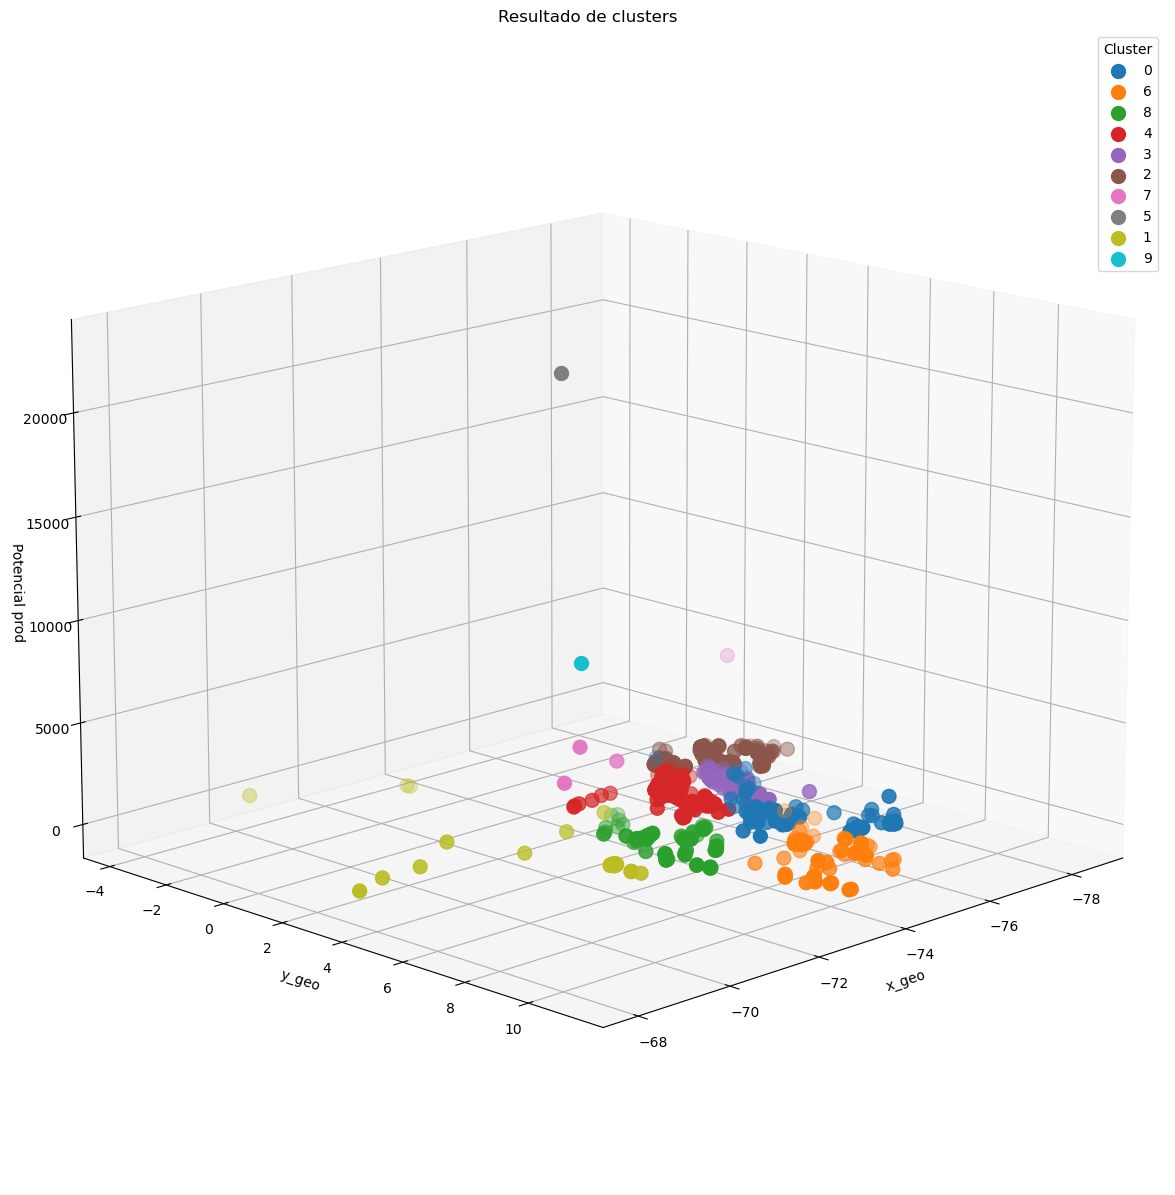

In [68]:
#Gráfico en 3D de las variables geográficas y potencial del rendimiento
plt.figure(figsize=(20, 15))
axes = plt.axes(projection = '3d')
for k in Xac.Cluster.unique():
    data = Xac[Xac.Cluster == k]
    x = data.x_geo
    y = data.y_geo
    z = data.potencial_prod
    axes.scatter3D( x, y, z, label=k, s=100)
plt.title('Resultado de clusters')
axes.set_xlabel('x_geo')
axes.set_ylabel('y_geo')
axes.set_zlabel('Potencial prod')
axes.view_init(15,45)
plt.legend(title='Cluster')
plt.show()

In [69]:
#Mapa de resultados de los Clusters
m = folium.Map(location=[4.570868, -74.297333], zoom_start=5)

colormap = LinearColormap(['lightblue', 'blue'], vmin=Xac['potencial_prod'].min(), vmax=Xac['potencial_prod'].max())

def asignar_color(row):
    group_color = {
        0: 'red',
        1: 'green',
        2: 'blue',
        3: 'purple',
        4: 'orange',
        5: 'pink',
        6: 'brown',
        7: 'gray',
        8: 'cyan',
        9: 'lime'
    }
    color = group_color.get(row['Cluster'], 'gray')
    return colormap(row['potencial_prod']), color

for index, row in Xac.iterrows():
    rendimiento_color, grupo_color = asignar_color(row)
    folium.CircleMarker(
        location=[row['y_geo'], row['x_geo']],
        radius=5,
        color=grupo_color,
        fill_color=rendimiento_color,
        fill_opacity=0.7,
    ).add_to(m)

m

#### Relación de algunas fuentes de interés

- Actualización y ajuste de la información
obtenida en el Estudio de Factibilidad del
Seguro Agrícola Catastrófico para el
cultivo de maíz blanco tradicional en los
departamentos de Antioquia y Tolima

https://www.finagro.com.co/sites/default/files/identificacion_beneficiarios_sac.pdf

- Archivo de datos: S06A(Cultivos)
Corresponde al inventario y prácticas agrícolas y pecuaria en la UPA y descripción básica de cultivos acuícolas. asi como la
sustentabilidad de la actividad agropecuaria, tanto en la gestión sobre recursos naturales como la gestión para la producción.

https://microdatos.dane.gov.co/index.php/catalog/513/data-dictionary/F15?file_name=S06A(Cultivos)